# 04.04 - COMPARING SAMPLES

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

replicating local resources


In [2]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from progressbar import progressbar as pbar
%matplotlib inline

## Comparing populations. A two-sided test

We have some exam scores for two groups of 10 students each

### STEP 1: Define the model you want to challenge (the NULL  Hypothesis $H_0$)

We define the $H_0$ as a model where there is no statistical difference between the two groups of students.

### STEP 2: Define your REAL WORLD sample and your test statistic

- **SAMPLE**: we sample two groups of 10 students exam scores each. We **KNOW** there is a difference (`mean_diff`) because we create the use case in such way. We want to see if the test detects it.

    - Can it detect it with larger/smaller group sizes?
    - Can it detect it with larger/smaller mean differences?

In [3]:
real_world_sample_size = 10
mu, sigma = 100, 10

def generate_AB(mu=mu, sigma=sigma, real_world_sample_size=real_world_sample_size, mean_diff=5):
    A = np.random.normal(loc=mu, scale=sigma, size=real_world_sample_size)
    B = np.random.normal(loc=mu+mean_diff, scale=sigma, size=real_world_sample_size)
    return A, B

A,B = generate_AB()
print ("group A  [", " ".join(["%6.2f"%i for i in A]), "]  mean %6.2f"%np.mean(A))
print ("group B  [", " ".join(["%6.2f"%i for i in B]), "]  mean %6.2f"%np.mean(B))


group A  [ 102.34  96.21 100.54 117.34  87.08 116.09 119.85 100.70 106.13 110.52 ]  mean 105.68
group B  [ 105.59 119.49 108.63 108.90 118.92 119.00 109.07 111.60 117.69 114.45 ]  mean 113.33


if we look at these two sets of scores, how sure can we be that their respective populations are different (different $\mu$)?


#### Define a test statistic to measure the mean difference of the samples

$$\text{ttest}(A,B) = \frac{\bar{A}-\bar{B}}{\sqrt{\frac{S_A^2}{N_A}+\frac{S_B^2}{N_B}}}$$

where:

- $\bar{A}$, $\bar{B}$ is the mean of the two real world samples
- $S_A$, $S_B$ is the standard deviation of the two real world samples
- $N_A$, $N_B$ is the size (number of elementso) of the two real world samples

The **denominator** factor is included so that we can compare the means with different standard deviations.


### STEP 3: We simulate $H_0$, and understand its distribution of $\text{ttest}$ 

individual student scores **NEED NOT** come from a normal disitribution. Regardless their origin, the distribution of the test statistic will be normal.

In [4]:
ttest = lambda a,b: (np.mean(a)-np.mean(b))/np.sqrt(np.std(a)**2/len(a)+np.std(b)**2/len(b))

n = 3000

a = np.r_[[stats.norm(loc=mu, scale=sigma).rvs(real_world_sample_size) for _ in pbar(range(n))]]
b = np.r_[[stats.norm(loc=mu, scale=sigma).rvs(real_world_sample_size) for _ in pbar(range(n))]]

t = np.r_[[ttest(i,j) for i,j in zip(a,b)]]

100% (3000 of 3000) |####################| Elapsed Time: 0:00:09 Time:  0:00:09
100% (3000 of 3000) |####################| Elapsed Time: 0:00:09 Time:  0:00:09


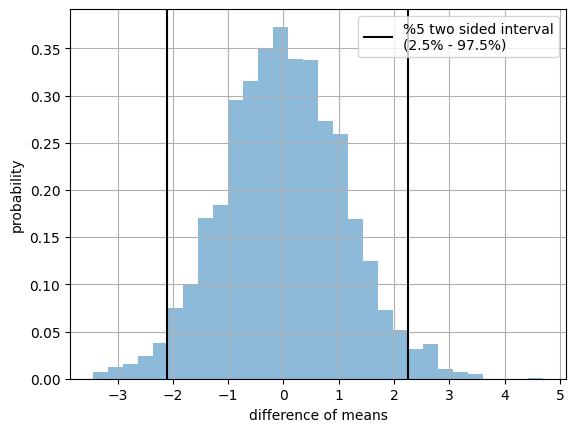

In [5]:
# A,B = generate_AB()

plt.hist( t, density=True, alpha=.5, bins=30);
plt.axvline(np.percentile(t,2.5), color="black", label="%5 two sided interval\n(2.5% - 97.5%) ")
plt.axvline(np.percentile(t,97.5), color="black")
plt.grid(); plt.legend(); 
plt.xlabel("difference of means"); plt.ylabel("probability")
plt.show()


### STEP 5: How rare is our real world sample w.r.t. $H_0$?

we measure how much probability mass is left outside the red dashed lines (our real world sample)

- small $p_{value}$ means our real world sample is rare
- large $p_{value}$ means our real world sample is quite common (expected)

For a confidence interval $\alpha=0.05$, if $p_{value}<\alpha$ we reject $H_0$ and consider $A$ and $B$ actually come from different populations.


observe we display $\text{ttest}(A,B)$ and $\text{ttest}(B,A)$ (red dashed lines) since we want to check if they are different in any direction

group A  [ 102.34  96.21 100.54 117.34  87.08 116.09 119.85 100.70 106.13 110.52 ]  mean 105.68
group B  [ 105.59 119.49 108.63 108.90 118.92 119.00 109.07 111.60 117.69 114.45 ]  mean 113.33


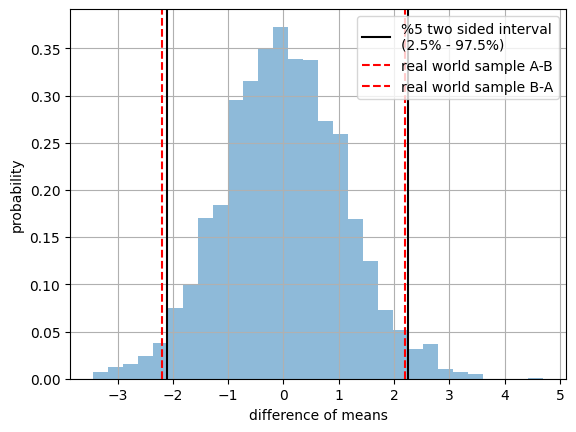

In [6]:
print ("group A  [", " ".join(["%6.2f"%i for i in A]), "]  mean %6.2f"%np.mean(A))
print ("group B  [", " ".join(["%6.2f"%i for i in B]), "]  mean %6.2f"%np.mean(B))


plt.hist( t, density=True, alpha=.5, bins=30);
plt.axvline(np.percentile(t,2.5), color="black", label="%5 two sided interval\n(2.5% - 97.5%) ")
plt.axvline(np.percentile(t,97.5), color="black")
plt.axvline(ttest(A,B), color="red", ls="--", label="real world sample A-B")
plt.axvline(ttest(B,A), color="red", ls="--", label="real world sample B-A")
plt.grid(); plt.legend(); 
plt.xlabel("difference of means"); plt.ylabel("probability")
plt.show()

In [7]:
#A,B = generate_AB()

k = np.mean( ttest(A,B)<t)
k = (k if k<0.5 else 1-k)*2
print ("empirical (simulated) p-value %.4f"%k)

empirical (simulated) p-value 0.0407


#### which corresponds to the value obtained with the analytical formula

As implemented in [`scipy.stats.ttest_ind`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html). With larger simulations, the result gets closer to the analytical formula.



In [8]:
stats.ttest_ind(A, B).pvalue

0.05139054363571296

## Understanding accuracy of large and small simulations

observe the relation between the empirical (simulated) and analytical $p_{value}$ is much tighter (more accurate) when the simulation is larger.

In [9]:

    
def test_simulations(n, mu=mu, sigma=sigma, real_world_sample_size=real_world_sample_size):
    a = np.r_[[stats.norm(loc=mu, scale=sigma).rvs(real_world_sample_size) for _ in pbar(range(n))]]
    b = np.r_[[stats.norm(loc=mu, scale=sigma).rvs(real_world_sample_size) for _ in pbar(range(n))]]

    t = np.r_[[ttest(A, B) for A,B in zip(a,b)]]
    r = []
    for _  in range(1000):
        A,B = generate_AB(mu=mu, sigma=sigma, real_world_sample_size=real_world_sample_size)
        ts = ttest(A,B)
        
        k = np.mean( ts<t)
        k = (k if k<0.5 else 1-k)*2
        r.append([k, stats.ttest_ind(A, B).pvalue])
    r = np.r_[r]
    
    plt.scatter(r[:,0], r[:,1], s=2)
    plt.grid(); plt.xlabel("empirical p-value"); plt.ylabel("analytical p-value")
    
    em, an = r[:,0], r[:,1]
    
    print ("p_value mean error simulated/analytic %.3f"%np.mean(np.abs(em-an)))
    print ("p_value mean error when p_value<0.05  %.3f"%np.mean(np.abs(em[an<0.05]-an[an<0.05])))

100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


p_value mean error simulated/analytic 0.037
p_value mean error when p_value<0.05  0.006


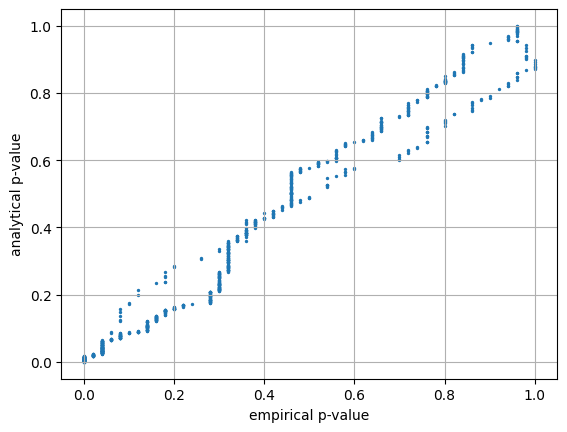

In [10]:
test_simulations(n=100, mu=mu, sigma=sigma)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (1000 of 1000) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


p_value mean error simulated/analytic 0.008
p_value mean error when p_value<0.05  0.002


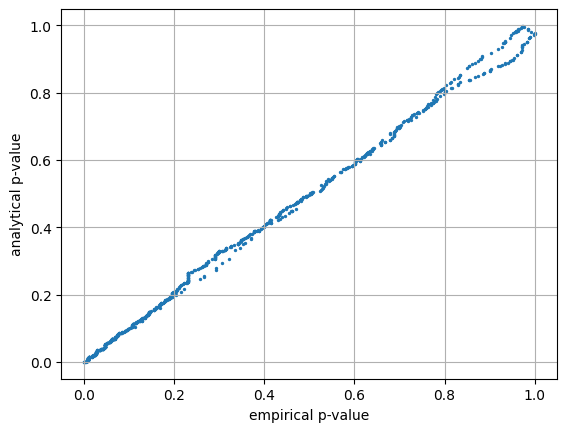

In [11]:
test_simulations(n=1000, mu=mu, sigma=sigma)

100% (6000 of 6000) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (6000 of 6000) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


p_value mean error simulated/analytic 0.006
p_value mean error when p_value<0.05  0.003


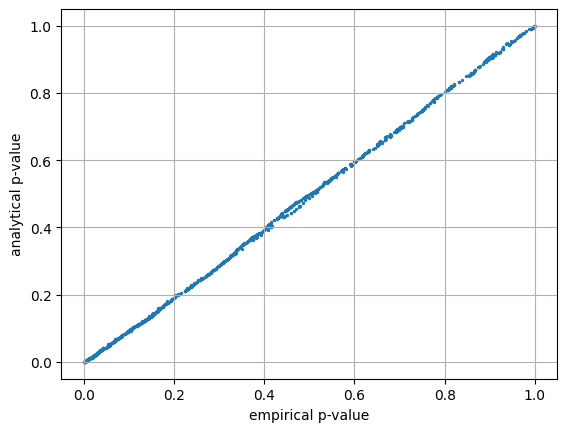

In [12]:
test_simulations(n=6000, mu=mu, sigma=sigma)




For more info:

- Sampling distribution of the sample mean [Khan Academy](https://www.khanacademy.org/math/ap-statistics/sampling-distribution-ap/sampling-distribution-mean/v/sampling-distribution-of-the-sample-mean)

- Central limit theorem [Wikipedia](https://en.wikipedia.org/wiki/Central_limit_theorem)

## Refs

- [scipy.stats.ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)
- [Wikipedia T-test](https://en.wikipedia.org/wiki/T-test#Independent_two-sample_t-test)